Task 1

In [48]:
import requests
import numpy as np
import pandas as pd
import string
from datetime import datetime
from urllib.parse import unquote
from bs4 import BeautifulSoup
import concurrent.futures 
from concurrent.futures import ThreadPoolExecutor, ALL_COMPLETED
from collections import OrderedDict
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# API Endpoints for Wikipedia and Wikidata
WIKIDATA_API_ENDPOINT = "https://www.wikidata.org/w/api.php"
WIKIPEDIA_API_ENDPOINT = "https://en.wikipedia.org/w/api.php"

# API Header to identify requestor for Wikipedia and Wikidata
HEADERS = {"User-Agent": "uni_coursework/2.0; nat.1.roongjirarat@kcl.ac.uk"}

# API Parameters for Wikipedia and Wikidata to get list of award winners, contennts of award winners' pages, and labels of award winners
PARAMS_QUERY_SEARCH = {
    "action":"query",
    "format":"json",
    "formatversion":"latest",
    "list":"search",
    "srsearch": "haswbstatement:P166=Q185667",
    "srlimit":"max"
}

PARAMS_GETCONTENT = {
    "action": "query",
    "format": "json",
    "titles": "",
    "prop": "extracts",
    "exlimit": "max"
}

PARAMS_WBGETENTITIES_LABELS = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "sites": "",
    "props": "labels",
    "languages": "en",
    "sitefilter": "enwiki",
    "utf8": 1,
    "ascii": 1,
    "formatversion": "latest"
}

PARAMS_WBGETENTITIES_SITES = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "sites": "",
    "props": "sitelinks/urls",
    "languages": "en",
    "sitefilter": "enwiki",
    "utf8": 1,
    "ascii": 1,
    "formatversion": "latest"
}

PARAMS_WBGETENTITIES_CLAIMS = {
    "action": "wbgetentities",
    "format": "json",
    "ids": "",
    "props": "claims",
    "languages": "en",
    "sitefilter": "",
    "formatversion": "latest"
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nat_rng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nat_rng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nat_rng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nat_rng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [49]:
def get_turing_award_recipients():
    """
    Function to return a list of Turing Award winners from Wikidata.

    Returns:
        list: Entity IDs of Turing Award winners, e.g. ['Q12345', 'Q23456', ...]
        this list is used in Task 3 to iterate over the list of Turing Award winners and get their contents from Wikipedia
        and properties from Wikidata.
    """
    acm_award_entities = []
    search_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_QUERY_SEARCH)
    data = search_response.json()
    for result in data['query']['search']:
        acm_award_entities.append(result['title'])
    return acm_award_entities

print(get_turing_award_recipients())

['Q80', 'Q3572699', 'Q92894', 'Q17457', 'Q92612', 'Q92638', 'Q92743', 'Q92824', 'Q181529', 'Q204815', 'Q578036', 'Q92794', 'Q92739', 'Q49823', 'Q92602', 'Q3571662', 'Q92626', 'Q62870', 'Q92758', 'Q16080922', 'Q8556', 'Q92604', 'Q357965', 'Q11609', 'Q92609', 'Q439245', 'Q92670', 'Q92819', 'Q92851', 'Q92613', 'Q62874', 'Q92854', 'Q92628', 'Q7143512', 'Q62861', 'Q320624', 'Q45575', 'Q1107006', 'Q92614', 'Q62888', 'Q93080', 'Q476466', 'Q92820', 'Q92649', 'Q62898', 'Q92641', 'Q92742', 'Q93154', 'Q62843', 'Q92643', 'Q92823', 'Q462089', 'Q62866', 'Q92629', 'Q92618', 'Q92822', 'Q92596', 'Q92746', 'Q918650', 'Q62857', 'Q92619', 'Q92821', 'Q62877', 'Q92781', 'Q92782', 'Q92632', 'Q93161', 'Q92744', 'Q92606', 'Q9602', 'Q92625', 'Q62894', 'Q92644', 'Q92745', 'Q92828']


Task 2

In [50]:
def get_wikipedia_content(entity_id):
    """
    Takes an enity ID or entity IDs (in the format Q111|Q111|...) of a Turing Award winner and returns the 
    content of the Wikipedia page of the Turing Award winner.

    Args:
        entity_id (str): The queery string of entity IDs, e.g. 'Q12345|Q23456|Q34567' or 'Q12345'

    Returns:
        str: Returns the HTML content of the Wikipedia page of the Turing Award winner/s as a string.
    """
    PARAMS_WBGETENTITIES_SITES["ids"] = entity_id
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_SITES)
    wbgetentities_data = wbgetentities_response.json()
    recipient_name = wbgetentities_data["entities"][entity_id]["sitelinks"]["enwiki"]["url"].split("https://en.wikipedia.org/wiki/")[1]
    try:
        PARAMS_GETCONTENT["titles"] = unquote(recipient_name)
        extracts_response = requests.get(WIKIPEDIA_API_ENDPOINT, headers=HEADERS, params=PARAMS_GETCONTENT)
        extracts_data = extracts_response.json()
        html_content = next(iter(extracts_data["query"]["pages"].values()))["extract"]
        content = BeautifulSoup(html_content, 'html.parser')
        if content.find("p", {"class":"mw-empty-elt"}):
            content.find("p", {"class":"mw-empty-elt"}).decompose()
        return str(content)
    except KeyError:
        return None

Task 3

In [25]:
def get_intro_data(entity_ids):
    """
    Takes a list of entity IDs of Turing Award winners and returns a dictionary of the intro of the Wikipedia page of the Turing Award winner/s.

    Args:
        entity_ids (list): List of entity IDs of Turing Award winners, e.g. ['Q12345', 'Q23456', ...] to retrieve the intro content of the Wikipedia
        page of the Turing Award winner/s.

    Returns:
        dict: Dictionary of the intro of the Wikipedia page of the Turing Award winner/s, with entity ID as the key and intro as the value,
        e.g. {'Q12345': 'This is the intro of Q12345', 'Q23456': 'This is the intro of Q23456', ...}
    """
    content_dict = dict()
    for entity_id in entity_ids:
        content_dict[entity_id] = get_wikipedia_content(entity_id).split("<h2>")[0]
    return content_dict

def get_wikidata_claims(entity_id):
    """
    Takes an entity ID of a Turing Award winner and returns the claims of the Wikidata page of the Turing Award winner.
    Claims are the properties of the Wikidata page of the Turing Award winner.
    
    Args:
        entity_id (str): The entity ID as a query string: 'Q12345'
        
    Returns:
        dict: Returns the claims of the Wikidata page of the Turing Award winner as a dictionary. The dictionary contains the 
        property ID as the key and property ID as the value.
    """
    PARAMS_WBGETENTITIES_CLAIMS["ids"] = entity_id
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_CLAIMS)
    wbgetentities_data = wbgetentities_response.json()
    claims = next(iter(wbgetentities_data["entities"].values()))["claims"]
    return claims

def get_wikidata_label(entity_query):
    """
    Takes an property ID or property IDs (in the format P111|P111|...) of a Turing Award winner and returns the label of the 
    Wikidata page corresponding to the property ID.
    
    Args:
        entity_query (str): The query string of property IDs, e.g. 'P12345|P23456|P34567' or 'P12345'
        
    Returns:
        dict: Returns the labels of the Wikidata page of the Turing Award winner/s as a dictionary. The dictionary contains the
        property ID as the key and the label as the value.
    """
    PARAMS_WBGETENTITIES_LABELS["ids"] = entity_query
    request_ids = set(entity_query.split("|"))
    request_labels = dict()
    wbgetentities_response = requests.get(WIKIDATA_API_ENDPOINT, headers=HEADERS, params=PARAMS_WBGETENTITIES_LABELS)
    wbgetentities_data = wbgetentities_response.json()
    for request_id in request_ids:
        labels = wbgetentities_data["entities"][request_id]["labels"]
        request_labels[request_id] = labels["en"]["value"]
    return request_labels

def check_key_exists(dict, key):
    """
    Verifies if a key exists in a Wikidata claims dictionary.

    Args:
        dict (dict): Input dictionary to verify if key exists.
        key (key): Key to check

    Returns:
        if Key exists: 
            list: List of all labels for a given property ID in the Wikidata claims dictionary.
        else    
            None: Return as None if key does not exist in dictionary.
    """
    if key in dict.keys():
        entity_ids = [dict[key][i]["mainsnak"]["datavalue"]["value"]["id"] for i in range(len(dict[key]))]
        return entity_ids
    else:
        return None

def call_wikidata_api(entity_id, content_dict):
    """
    Cal the wikidata API to retrieve the Wikidata labels for all properrties in the Turing Award winner Wikidata Page.
    Also retrieves the intro of the Wikipedia page of the Turing Award winner from a content dictionary.
    Args:
        entity_id (str): Entity ID of the Turing Award winner.
        content_dict (dict): Content dictionary of the intros from the Wikipedia pages of the Turing Award winners.

    Returns:
        name (str): Name of the Turing Award winner.
        intro (str): Intro of the Wikipedia page of the Turing Award winner as an HTML string.
        gender (str): Gender of the Turing Award winner.
        birth_date (DateTime): Birth date of the Turing Award winner as a datetime object.
        birth_city (str): Birth city of the Turing Award winner.
        employers (list): List of employers of the Turing Award winner.
        educated_at (list): List of institutions the Turing Award winner was educated at.
    """
    wiki_data_dict = {"gender": "P21", "birth_date": "P569", "birth_city": "P19", 
                  "birth_country": "P17", "employer": "P108", "educated_at": "P69"}
    claims = get_wikidata_claims(entity_id)
    request_entityids = {"name_id": [entity_id], "gender_id": check_key_exists(claims, wiki_data_dict["gender"]),
                       "birth_city_id" : check_key_exists(claims, wiki_data_dict["birth_city"]),
                       "employers_ids": check_key_exists(claims, wiki_data_dict["employer"]),
                       "educated_at_ids": check_key_exists(claims, wiki_data_dict["educated_at"])}
    
    
    entity_query = "|".join(["|".join(values) for values in request_entityids.values() if values != None])
    request_labels = get_wikidata_label(entity_query)
    
    try:
        name = request_labels[entity_id].split(" (")[0]
    except TypeError:
        name = None
    intro = content_dict[entity_id]
    try: 
        gender = request_labels[request_entityids["gender_id"][0]]
    except TypeError:
        gender = None
    try:
        birth_date = datetime.strptime(claims[wiki_data_dict["birth_date"]][0]["mainsnak"]["datavalue"]["value"]["time"], "+%Y-%m-%dT%XZ").strftime("%d %B %Y")
    except ValueError:
        birth_date = datetime.strptime(claims[wiki_data_dict["birth_date"]][0]["mainsnak"]["datavalue"]["value"]["time"], "+%Y-00-00T%XZ").strftime("%Y")
    except TypeError:
        birth_date = None
    try:
        birth_place = request_labels[request_entityids["birth_city_id"][0]] 
    except TypeError:
        birth_place = None
    if request_entityids["employers_ids"] != None:
        employer = list(OrderedDict.fromkeys([request_labels[key] for key in request_entityids["employers_ids"]]))
    else:
        employer = None
    if request_entityids["employers_ids"] != None:
        education = list(OrderedDict.fromkeys([request_labels[key] for key in request_entityids["educated_at_ids"]]))
    else:
        education = None
    return name, intro, gender, birth_date, birth_place, employer, education

def multi_thread_api_call(intro_dict, workers=10):
    """
    Multi Threaded API call to retrieve the Wikidata labels for all properties in the Turing Award winner Wikidata Page and 
    corresponding Wikipedia page. Defaults to 10 workers to make concourrent API calls. If a worker fails, it will retry the API call until
    all API calls are successful.
    
    Args:
        intro_dict (dict): Dicitionary of the intros from the Wikipedia pages of the Turing Award winners. Where the key is the entity ID and the value is the intro.
        workers (int, optional): Number of workers to make concurrnet API calls. Defaults to 10.

    Returns:
        list: The result of the API call for each Turing Award winner. Each item in the list is a tuple with the following structure:
        (name, intro, gender, birth_date, birth_place, employer, education)
    """
    results = []
    
    with ThreadPoolExecutor(max_workers=workers) as executor:
        api_calls = {executor.submit(call_wikidata_api, entity_id, intro_dict): entity_id for entity_id in intro_dict.keys()}
        while api_calls:
            retry_api_calls = {}
            done = concurrent.futures.wait(api_calls, return_when=ALL_COMPLETED)
            for api_call in done:
                for future in api_call:
                    if future.exception():
                        entity_id = api_calls[future]
                        retry_api_calls[executor.submit(call_wikidata_api, entity_id, intro_dict)] = entity_id
                    else:
                        results.append(future.result())
            api_calls = retry_api_calls   
    return results

def get_award_winners_data(results):
    """
    Takes an input list containing the results of the API call for each Turing Award winner and returns a dictionary with the following structure:
    {"name": [], "intro": [], "gender": [], "birth_date": [], "birth_place": [], "employer": [], "educated_at": []} 
    
    Args:
        results (tuple): Tuple with the following format (name, intro, gender, birth_date, birth_place, employer, education)
        to unpack and append to each list in the dictionary.

    Returns:
        dict: Dictionary of all award winners with the following structure, order is dependent on the API call execution order
        eeach value is stored in a list: 
        {"name": [], "intro": [], "gender": [], "birth_date": [], "birth_place": [], "employer": [], "educated_at": []} 
        
    See Also:
        def multi_thread_api_call(intro_dict, workers=10)
    """
    award_winners_dict = {"name": [], "intro": [], "gender": [], "birth_date": [], 
                      "birth_place": [], "employer": [], "educated_at": []} 
    for result in results:
        name, intro, gender, birth_date, birth_place, employer, education = result
        award_winners_dict["name"].append(name)
        award_winners_dict["intro"].append(intro)
        award_winners_dict["gender"].append(gender)
        award_winners_dict["birth_date"].append(birth_date)
        award_winners_dict["birth_place"].append(birth_place)
        award_winners_dict["employer"].append(employer)
        award_winners_dict["educated_at"].append(education)
    return award_winners_dict

In [26]:
# Get the list of Turing Award winners by Entity ID
acm_award_winners = get_turing_award_recipients()
# Get the intro from the Wikipedia page for each Turing Award winner as a dictionary
winner_intros = get_intro_data(acm_award_winners)
# List of tuples returned from the API call for each Turing Award winner (random order)
api_calls = multi_thread_api_call(winner_intros)
#Dictionary containing the data for each Turing Award winner
award_winners = get_award_winners_data(api_calls)

Task 4

In [53]:
# Print the names of the Turing Award winners in alphabetical order
for name in sorted(award_winners["name"]):
    print(name)

Adi Shamir
Alan Kay
Alan Perlis
Alfred Aho
Allen Newell
Amir Pnueli
Andrew Yao
Barbara Liskov
Bob Kahn
Butler Lampson
Charles Bachman
Charles P. Thacker
Dana Scott
David A. Patterson
Dennis M. Ritchie
Donald Knuth
Douglas Engelbart
E. Allen Emerson
Edgar F. Codd
Edmund M. Clarke
Edsger W. Dijkstra
Edward Feigenbaum
Edwin Catmull
Fernando J. Corbató
Frances E. Allen
Fred Brooks
Geoffrey Hinton
Herbert Simon
Iosif Sifakis
Ivan Sutherland
Jack Dongarra
James H. Wilkinson
Jeffrey David Ullman
Jim Gray
John Backus
John Cocke
John Edward Hopcroft
John L. Hennessy
John McCarthy
Judea Pearl
Juris Hartmanis
Ken Thompson
Kenneth E. Iverson
Kristen Nygaard
Leonard Adleman
Leslie Lamport
Leslie Valiant
Manuel Blum
Martin Edward Hellman
Marvin Minsky
Maurice Wilkes
Michael O. Rabin
Michael Stonebraker
Niklaus Wirth
Ole-Johan Dahl
Pat Hanrahan
Peter Naur
Raj Reddy
Richard E. Stearns
Richard Hamming
Richard M. Karp
Robert Tarjan
Robert W. Floyd
Robin Milner
Ron Rivest
Shafrira Goldwasser
Silvio Mical

Task 5

In [54]:
award_winners_intro = pd.DataFrame(columns=["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"])
award_winners_intro["winner_name"] = award_winners["name"]

def get_intro_stats(intro): 
    intro_html = BeautifulSoup(intro, "html.parser")
    intro_text = intro_html.get_text(" ")
    count_words = sum([word.strip(string.punctuation).isalnum() for word in intro_text.split()])
    count_sentences = len(sent_tokenize(intro_text))
    count_paragraphs = len(intro_html.find_all("p"))
    word_filter = set(list(string.punctuation) + ["``", "''", "–"])
    word_freqdist= nltk.FreqDist([word for word in word_tokenize(intro_text) if word not in word_filter]).most_common(10)
    common_words = [word[0] for word in word_freqdist]
    return count_words, count_sentences, count_paragraphs, common_words

intro_stats = {"word_count": [], "sentence_count": [], "paragraph_count": [], "common_words": []}
for intro in award_winners["intro"]:
    count_word, count_sentences, count_paragraphs, common_words = get_intro_stats(intro)
    intro_stats["word_count"].append(count_word)
    intro_stats["sentence_count"].append(count_sentences)
    intro_stats["paragraph_count"].append(count_paragraphs)
    intro_stats["common_words"].append(common_words)

award_winners_intro["count_words"] = intro_stats["word_count"]
award_winners_intro["count_sentences"] = intro_stats["sentence_count"]
award_winners_intro["count_paragraphs"] = intro_stats["paragraph_count"]
award_winners_intro["common_words"] = intro_stats["common_words"]

award_winners_intro

,winner_name,count_words,count_sentences,count_paragraphs,common_words
0,Richard E. Stearns,119,6,2,"[the, of, in, a, Stearns, is, University, with..."
1,Niklaus Wirth,52,3,1,"[computer, a, several, languages, in, the, Nik..."
2,Raj Reddy,126,6,1,"[of, the, He, is, in, to, and, Turing, Award, ..."
3,James H. Wilkinson,37,1,1,"[a, the, field, of, and, James, Hardy, Wilkins..."
4,Vint Cerf,62,2,1,"[the, of, and, is, Internet, National, Medal, ..."
5,Yoshua Bengio,90,4,2,"[and, the, of, Bengio, for, is, a, work, deep,..."
6,Edmund M. Clarke,59,3,1,"[and, Clarke, was, for, the, Edmund, Melson, J..."
7,Jim Gray,36,1,1,"[in, and, James, Nicholas, Gray, 1944, declare..."
8,Dana Scott,83,3,1,"[the, is, of, and, in, University, work, on, t..."
9,Manuel Blum,37,1,1,"[the, of, to, and, Manuel, Blum, born, 26, Apr..."


Task 5

In [24]:
def process_top10_common_words(intro):
    intro_text = BeautifulSoup(intro, "html.parser").get_text(" ")
    word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
    tokenized_intro = word_tokenize(intro_text)
    word_freqdist = nltk.FreqDist([word for word in tokenized_intro if word.lower() not in word_filter]).most_common(10)
    common_words = [word[0] for word in word_freqdist]
    return common_words

common_words_after_preprocessing = [process_top10_common_words(intro) for intro in award_winners["intro"]]
award_winners_intro["common_words_after_preprocessing"] = common_words_after_preprocessing

print(award_winners_intro.head(10))

              winner_name  count_words  count_sentences  count_paragraphs  \
0      Richard E. Stearns          119                6                 2   
1          Leslie Lamport          111                5                 1   
2           John McCarthy           97                5                 2   
3                Alan Kay          123                7                 2   
4           William Kahan           46                1                 1   
5         Richard M. Karp           91                3                 2   
6           Niklaus Wirth           52                3                 1   
7        Whitfield Diffie          148                6                 2   
8           Robert Tarjan           59                3                 1   
9           Iosif Sifakis           30                2                 1   
10            Judea Pearl          154                5                 2   
11   John Edward Hopcroft           78                3                 1   

3.2 Sub Activity

Task 3

In [56]:
def process_intro_words(intro):
    word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])
    tokenized_intro = word_tokenize(intro)
    intro_words = [word for word in tokenized_intro if word.lower() not in word_filter]
    return intro_words

def count_unique_words(intro):
    unique_intro_words = [word.lower() for word in intro]
    return len(list(nltk.FreqDist(unique_intro_words)))

long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)
original_unique_words = count_unique_words(intro_words)

print("Number of unique words before stemming with Porter Stemmer: {}".format(original_unique_words))

porter_stemmer = PorterStemmer()
intro_words_with_porterstemmer = [porter_stemmer.stem(word) for word in intro_words]

print("Number of unique words after stemming with Porter Stemmer: {}".format(len(list(nltk.FreqDist(intro_words_with_porterstemmer)))))

Number of unique words before stemming with Porter Stemmer: 1644
Number of unique words after stemming with Porter Stemmer: 1442


Task 4

In [57]:
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)
original_unique_words = count_unique_words(intro_words)

print("Number of unique words before stemming with Porter Stemmer: {}".format(original_unique_words))

snow_stemmer = SnowballStemmer(language='english')
intro_words_with_snowballstemmer = [snow_stemmer.stem(word) for word in intro_words]

print("Number of unique words after stemming with Snowball Stemmer: {}".format(len(list(nltk.FreqDist(intro_words_with_snowballstemmer)))))

Number of unique words before stemming with Porter Stemmer: 1644
Number of unique words after stemming with Snowball Stemmer: 1440


Task 5

In [68]:
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)
original_unique_words = count_unique_words(intro_words)

print("Number of unique words before stemming with Porter Stemmer: {}".format(original_unique_words))

wordnet_lemmatizer = WordNetLemmatizer()
intro_words_wordnetlemmatizer = [wordnet_lemmatizer.lemmatize(word.lower()) for word in intro_words]

print("Number of unique words after lemmatization with Word Net Lemmatizer: {}".format(len(list(nltk.FreqDist(intro_words_wordnetlemmatizer)))))

Number of unique words before stemming with Porter Stemmer: 1644
Number of unique words after lemmatization with Word Net Lemmatizer: 1580


Task 6

In [59]:
award_winners_intro = award_winners_intro.assign(synonyms = np.nan, antonyms = np.nan)
common_words_after_preprocessing = award_winners_intro["common_words_after_preprocessing"]

def get_synonyms(common_words):
    synonyms = [l.name() for word in common_words for syn in wordnet.synsets(word) for l in syn.lemmas() if l.name() != word]
    return list(OrderedDict.fromkeys(synonyms))

def get_antonyms(common_words):
    antonyms = [l.antonyms()[0].name() for word in common_words for syn in wordnet.synsets(word) for l in syn.lemmas() if l.antonyms()]
    return list(OrderedDict.fromkeys(antonyms))

for i in range(len(common_words_after_preprocessing)):
    common_words = common_words_after_preprocessing[i]
    synonyms, antonyms = get_synonyms(common_words), get_antonyms(common_words)
    award_winners_intro["synonyms"].iloc[i] = synonyms
    award_winners_intro["antonyms"].iloc[i] = antonyms

award_winners_intro.head(10)

['Stearns', 'University', 'received', 'mathematics', 'Richard', 'Edwin', 'born', 'July', '5', '1936']
['computer', 'several', 'languages', 'Niklaus', 'Emil', 'Wirth', 'born', '15', 'February', '1934']
['Turing', 'Award', 'artificial', 'intelligence', 'Carnegie', 'Mellon', 'Institute', 'University', 'Dabbala', 'Rajagopal']
['field', 'James', 'Hardy', 'Wilkinson', 'FRS', '27', 'September', '1919', '5', 'October']
['Internet', 'National', 'Medal', 'Vinton', 'Gray', 'Cerf', 'born', 'June', '23', '1943']
['Bengio', 'work', 'deep', 'learning', 'Learning', 'Hinton', 'LeCun', 'Godfathers', 'Yoshua', 'born']
['Clarke', 'Edmund', 'Melson', 'Jr.', 'July', '27', '1945', 'December', '22', '2020']
['James', 'Nicholas', 'Gray', '1944', 'declared', 'dead', 'absentia', '2012', 'American', 'computer']
['University', 'work', 'theory', 'Dana', 'Stewart', 'Scott', 'born', 'October', '11', '1932']
['Manuel', 'Blum', 'born', '26', 'April', '1938', 'Venezuelan-American', 'computer', 'scientist', 'received']
[

/tmp/ipykernel_184/3494678481.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  award_winners_intro["synonyms"].iloc[i] = synonyms
/tmp/ipykernel_184/3494678481.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  award_winners_intro["antonyms"].iloc[i] = antonyms


,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Richard E. Stearns,119,6,2,"[the, of, in, a, Stearns, is, University, with...","[Stearns, University, received, mathematics, R...","[university, receive, have, get, find, obtain,...","[say_farewell, nonstandard, unborn]"
1,Niklaus Wirth,52,3,1,"[computer, a, several, languages, in, the, Nik...","[computer, several, languages, Niklaus, Emil, ...","[computing_machine, computing_device, data_pro...",[unborn]
2,Raj Reddy,126,6,1,"[of, the, He, is, in, to, and, Turing, Award, ...","[Turing, Award, artificial, intelligence, Carn...","[Alan_Turing, Alan_Mathison_Turing, award, awa...","[natural, stupidity]"
3,James H. Wilkinson,37,1,1,"[a, the, field, of, and, James, Hardy, Wilkins...","[field, James, Hardy, Wilkinson, FRS, 27, Sept...","[battlefield, battleground, field_of_battle, f...",[free]
4,Vint Cerf,62,2,1,"[the, of, and, is, Internet, National, Medal, ...","[Internet, National, Medal, Vinton, Gray, Cerf...","[internet, net, cyberspace, national, subject,...","[international, local, unborn]"
5,Yoshua Bengio,90,4,2,"[and, the, of, Bengio, for, is, a, work, deep,...","[Bengio, work, deep, learning, Learning, Hinto...","[piece_of_work, employment, study, workplace, ...","[idle, malfunction, shallow, unborn]"
6,Edmund M. Clarke,59,3,1,"[and, Clarke, was, for, the, Edmund, Melson, J...","[Clarke, Edmund, Melson, Jr., July, 27, 1945, ...","[younger, jr., twenty-seven, XXVII, xxvii, Dec...",[]
7,Jim Gray,36,1,1,"[in, and, James, Nicholas, Gray, 1944, declare...","[James, Nicholas, Gray, 1944, declared, dead, ...","[James_IV, James_II, James_I, King_James, King...","[free, undeclared, living, alive, live]"
8,Dana Scott,83,3,1,"[the, is, of, and, in, University, work, on, t...","[University, work, theory, Dana, Stewart, Scot...","[university, piece_of_work, employment, study,...","[idle, malfunction, unborn]"
9,Manuel Blum,37,1,1,"[the, of, to, and, Manuel, Blum, born, 26, Apr...","[Manuel, Blum, born, 26, April, 1938, Venezuel...","[Born, Max_Born, bear, give_birth, deliver, bi...","[unborn, say_farewell, nonstandard]"


Task 7

In [60]:
long_intro_text = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
intro_words = process_intro_words(long_intro_text)

Task 8

In [61]:
def get_bigrams_frequency(words_list):
    bigrams = nltk.bigrams(words_list)
    bigrams_freqdist = nltk.FreqDist(bigrams)
    return dict(bigrams_freqdist)

Task 9

In [62]:
winners_bigrams = get_bigrams_frequency(intro_words)

Task 10

In [63]:
top15_bigrams = dict(sorted(winners_bigrams.items(), key=lambda bigram_dict: bigram_dict[1], reverse=True)[:15])
print("Top 15 bigrams: {}".format(", ".join([str(bigram) for bigram in top15_bigrams.keys()])))

Top 15 bigrams: ('computer', 'scientist'), ('Turing', 'Award'), ('American', 'computer'), ('computer', 'science'), ('Computer', 'Science'), ('programming', 'language'), ('best', 'known'), ('programming', 'languages'), ('artificial', 'intelligence'), ('National', 'Academy'), ('received', 'Turing'), ('Carnegie', 'Mellon'), ('Academy', 'Engineering'), ('Professor', 'Computer'), ('Stanford', 'University')


Task 11

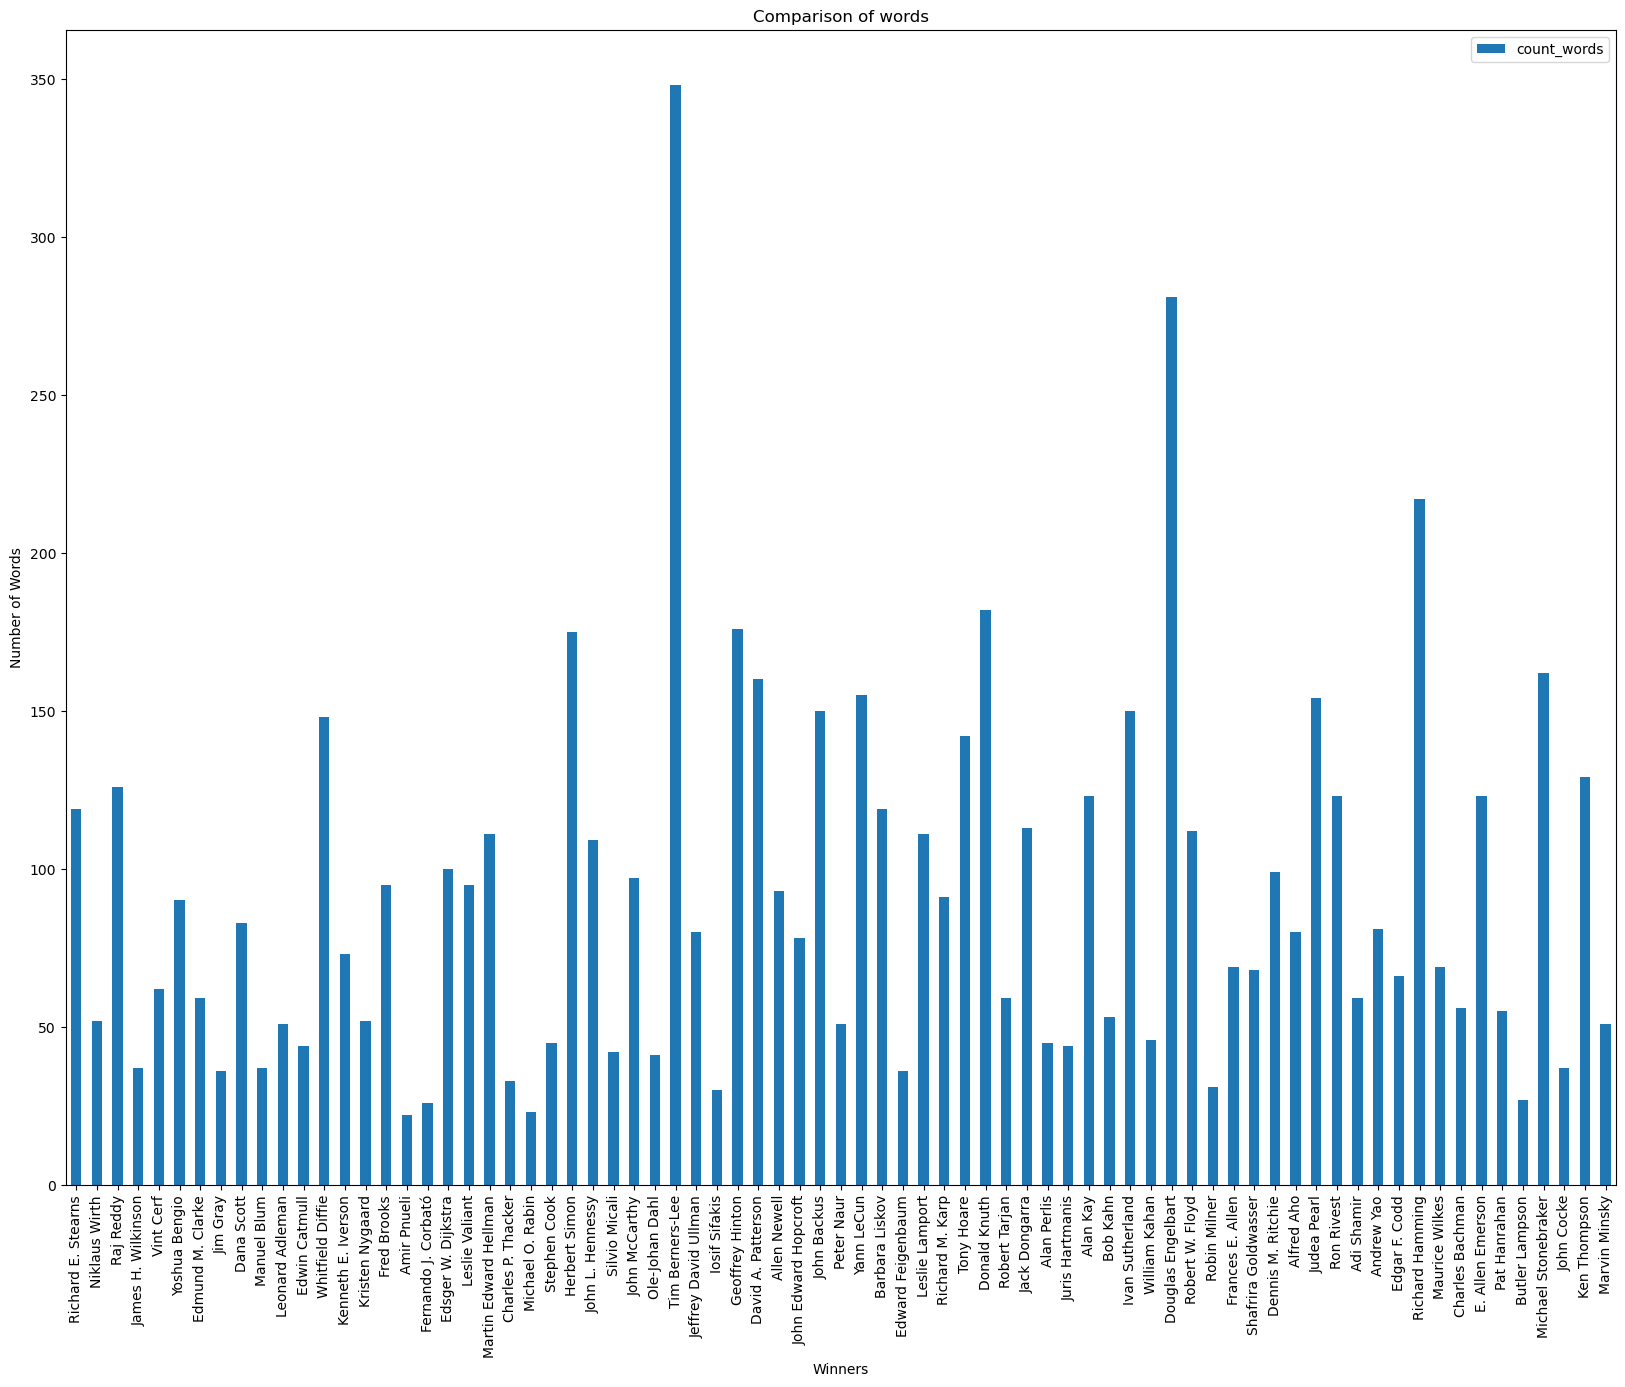

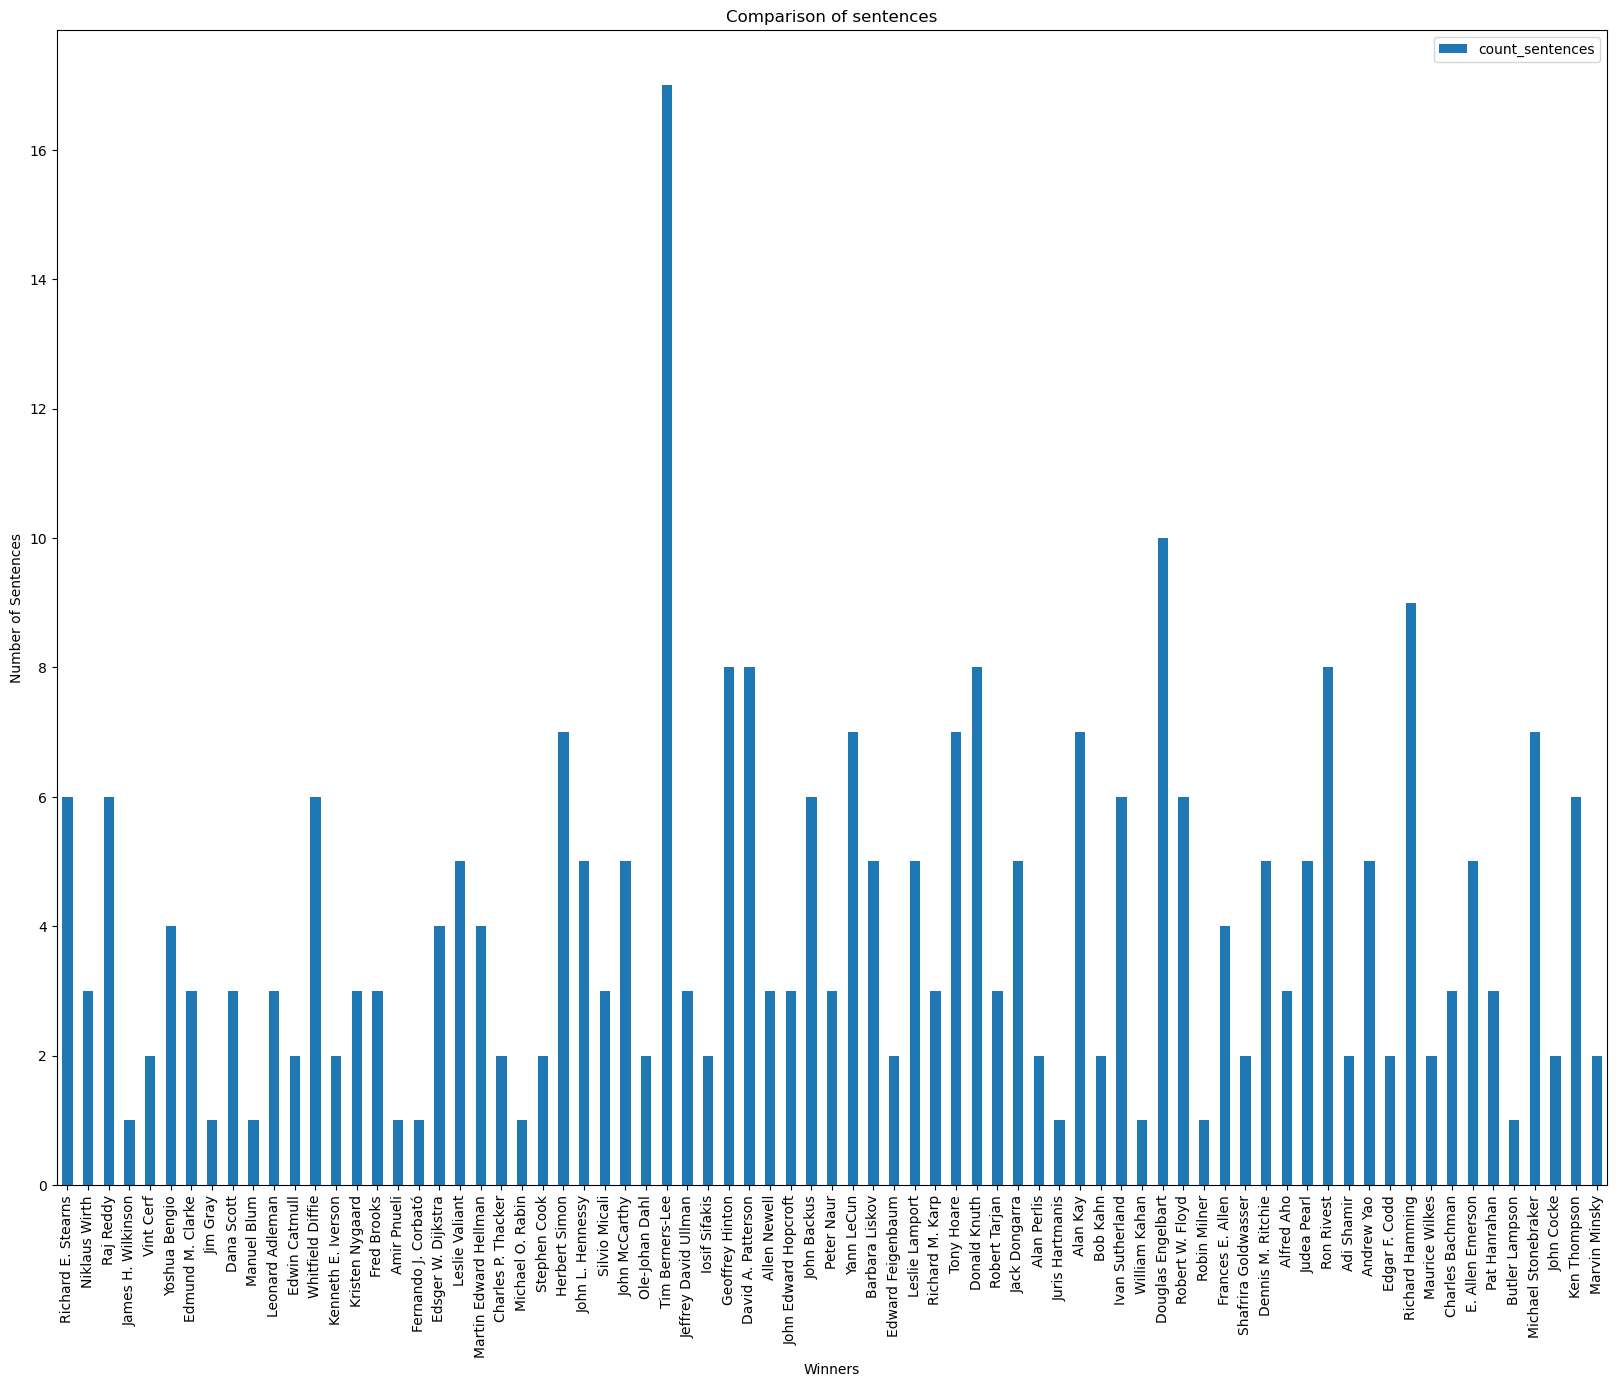

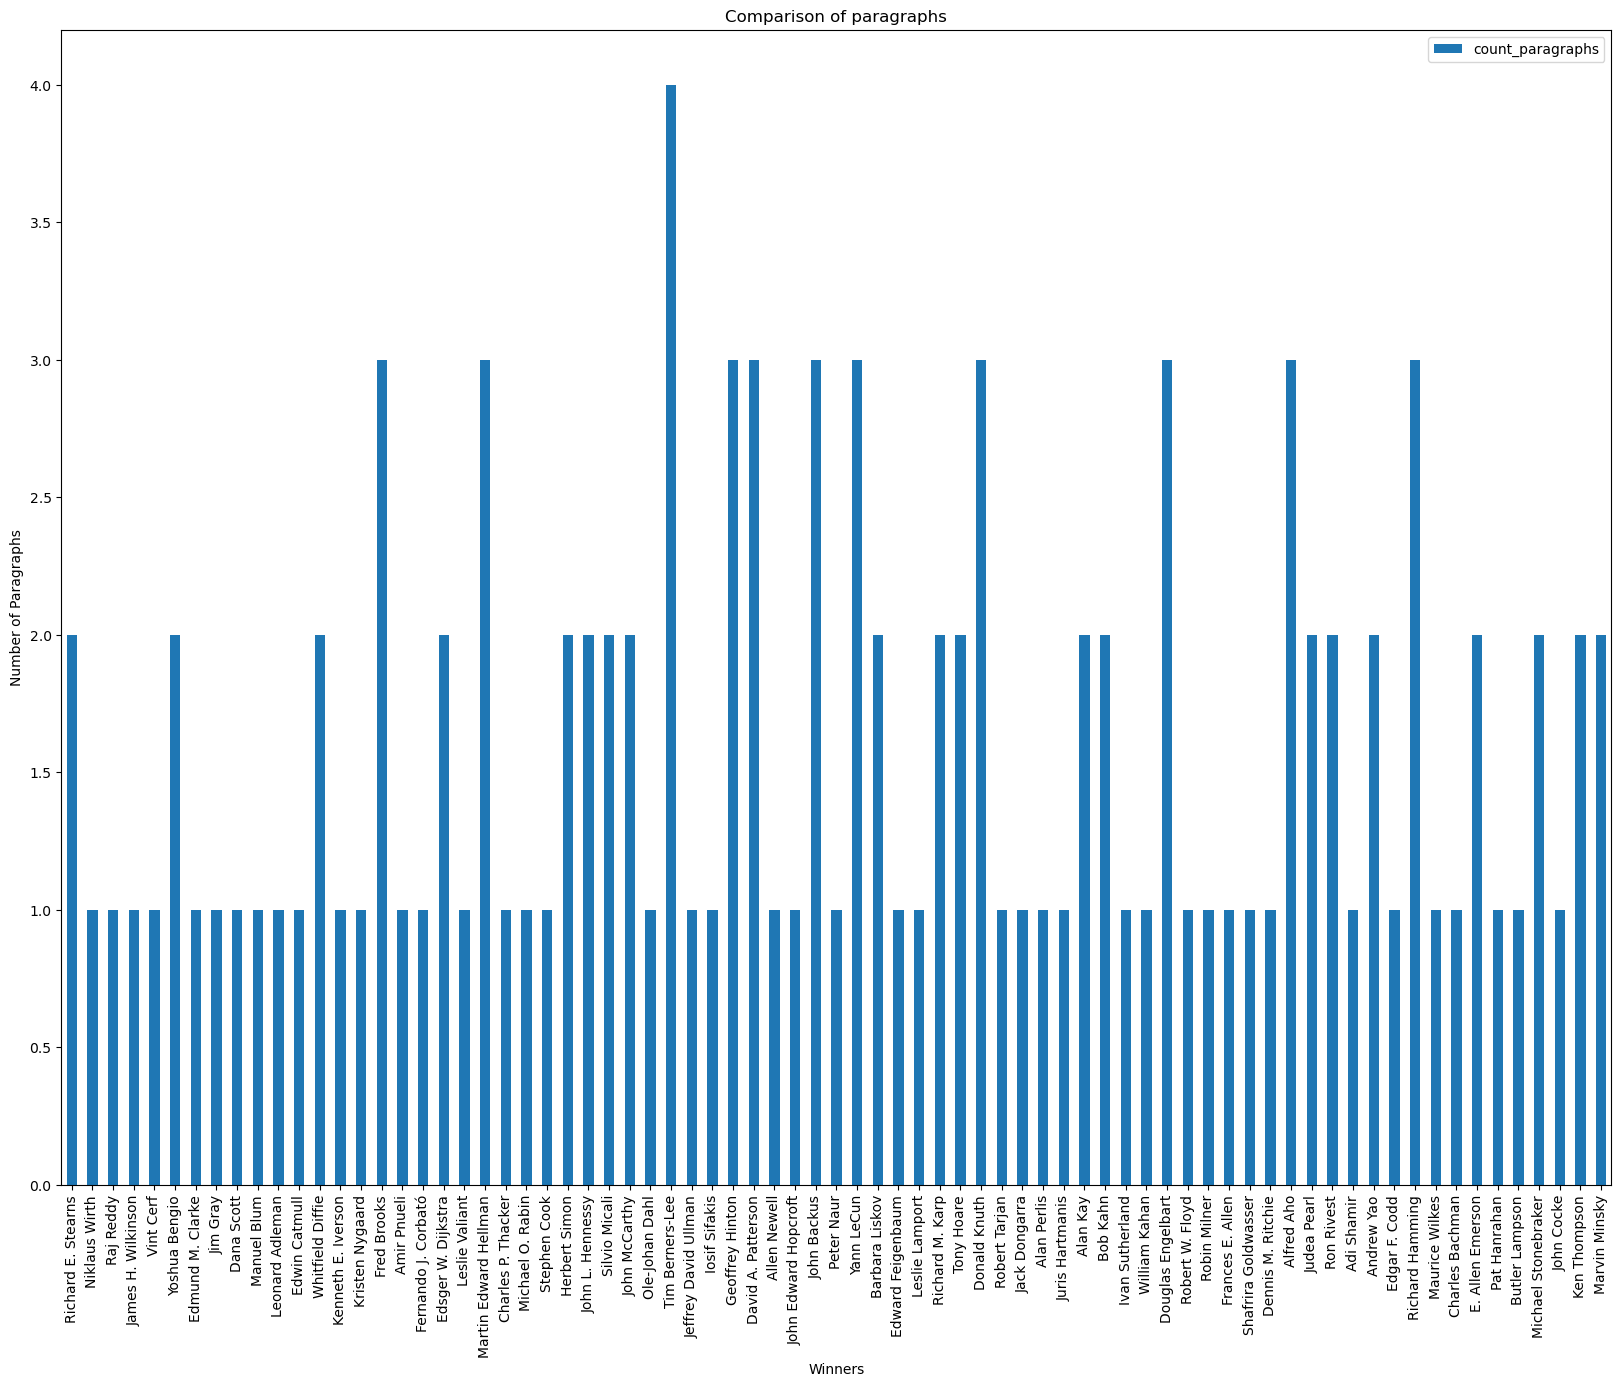

In [64]:
word_comparison = award_winners_intro.plot(x="winner_name", y="count_words", kind='bar', title ="Comparison of words", 
                                           figsize=(20, 15), legend=True)
word_comparison.set_xlabel("Winners")
word_comparison.set_ylabel("Number of Words")
plt.show()

sentence_comparison = award_winners_intro.plot(x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentences", 
                                               figsize=(20, 15), legend=True)
sentence_comparison.set_xlabel("Winners")
sentence_comparison.set_ylabel("Number of Sentences")
plt.xticks(range(len(award_winners_intro["winner_name"])), award_winners_intro["winner_name"])
plt.show()

paragraph_comparison = award_winners_intro.plot(x="winner_name", y="count_paragraphs", kind='bar', title ="Comparison of paragraphs", 
                                                figsize=(20, 15), legend=True)
paragraph_comparison.set_xlabel("Winners")
paragraph_comparison.set_ylabel("Number of Paragraphs")
plt.xticks(range(len(award_winners_intro["winner_name"])), award_winners_intro["winner_name"])
plt.show()

Task 12

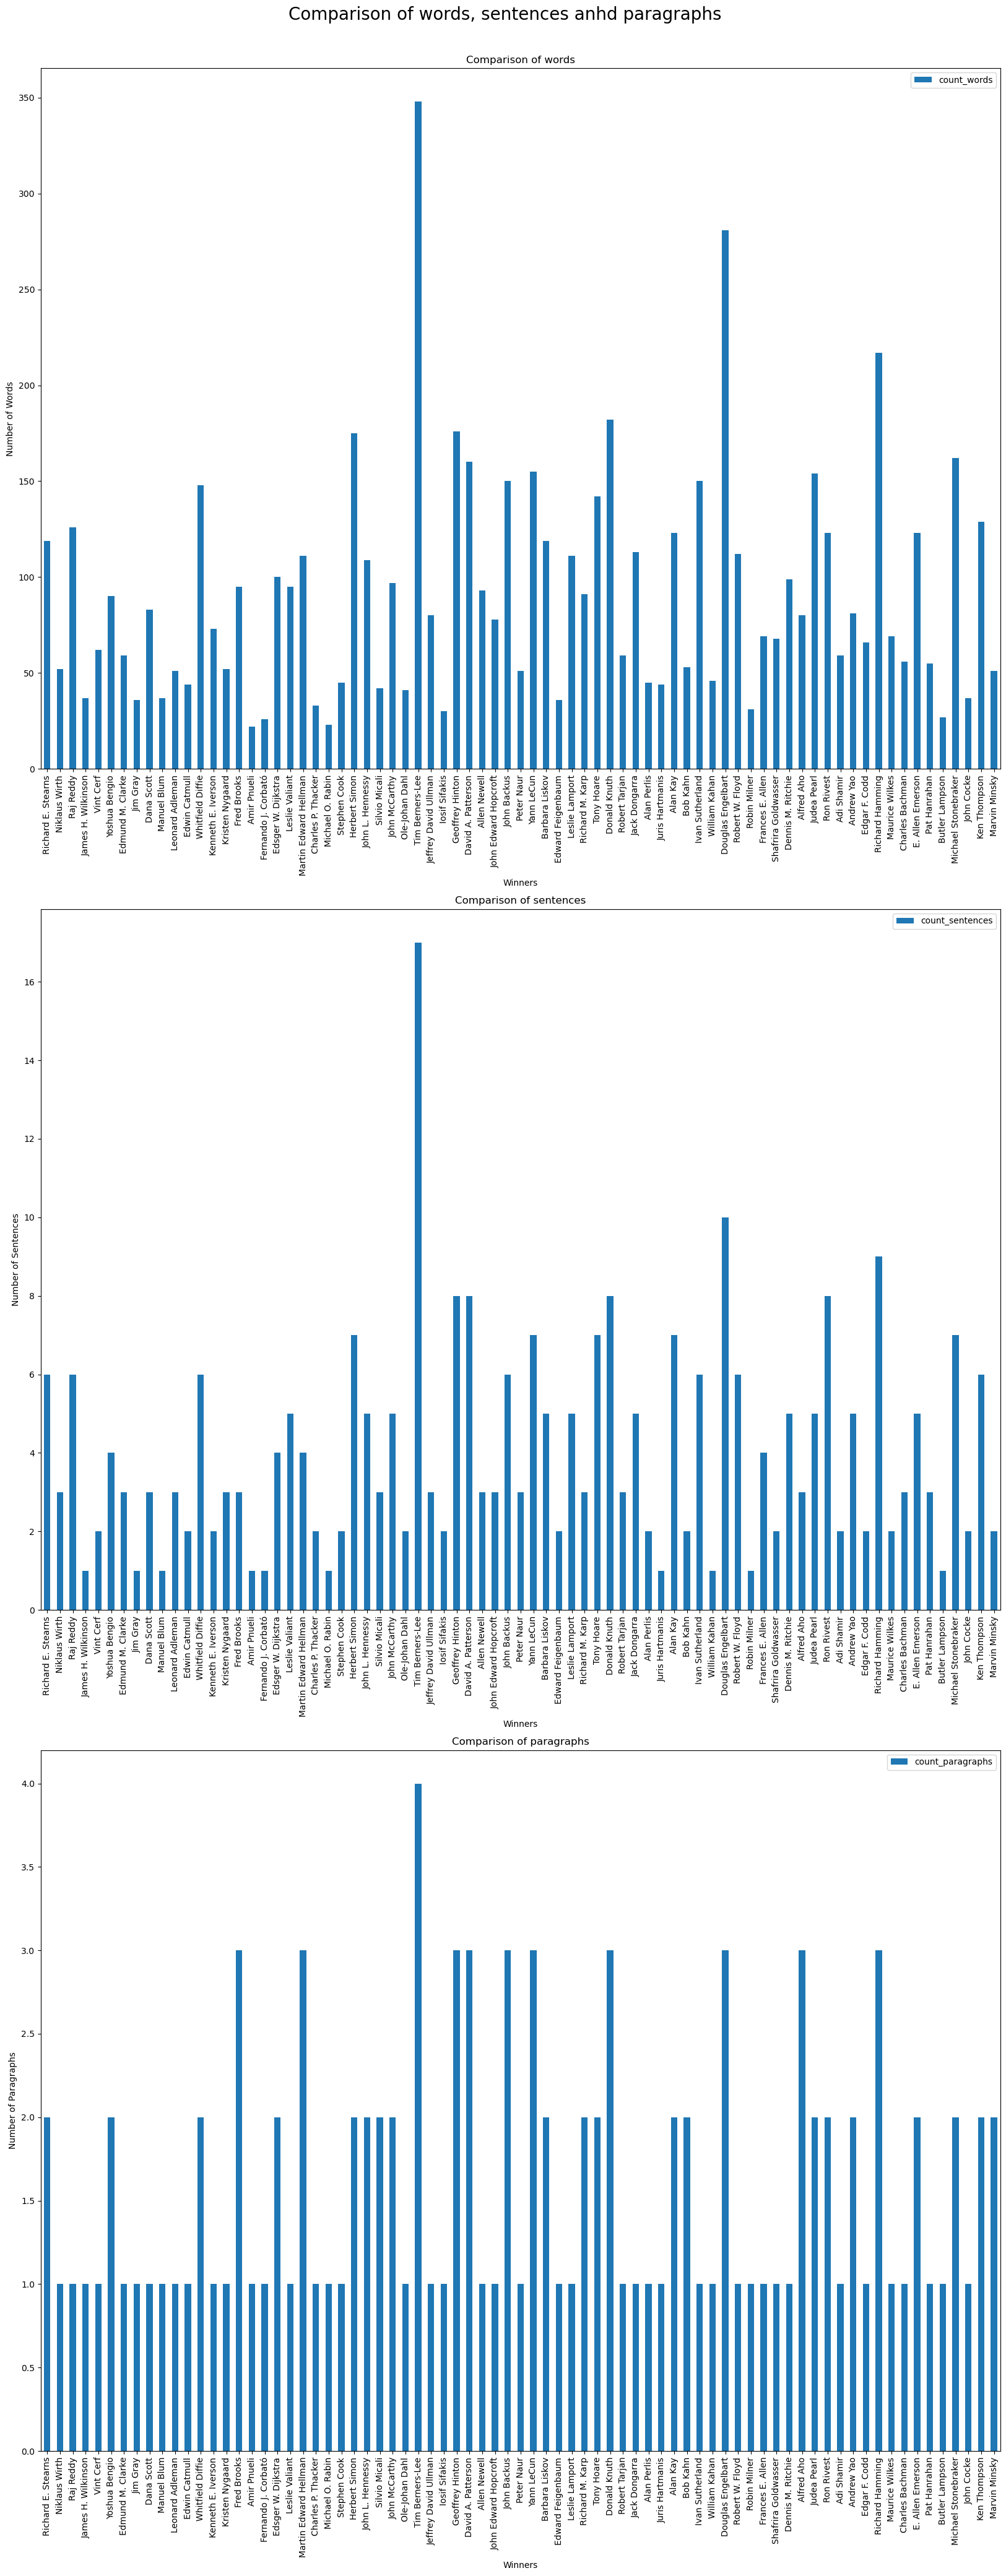

In [65]:
fig, axes = plt.subplots(3, figsize=(20, 50))
fig.suptitle("Comparison of words, sentences anhd paragraphs", x = 0.5, y = 0.90, fontsize = 20)

word_comparison = award_winners_intro.plot(ax = axes[0], x="winner_name", y="count_words", kind='bar', title ="Comparison of words", 
                                           legend=True)
word_comparison.set_xlabel("Winners")
word_comparison.set_ylabel("Number of Words")

sentence_comparison = award_winners_intro.plot(ax = axes[1], x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentences", 
                                               legend=True)
sentence_comparison.set_xlabel("Winners")
sentence_comparison.set_ylabel("Number of Sentences")

paragraph_comparison = award_winners_intro.plot(ax = axes[2], x="winner_name", y="count_paragraphs", kind='bar', title ="Comparison of paragraphs", 
                                                legend=True)
paragraph_comparison.set_xlabel("Winners")
paragraph_comparison.set_ylabel("Number of Paragraphs")

plt.show()

Task 13

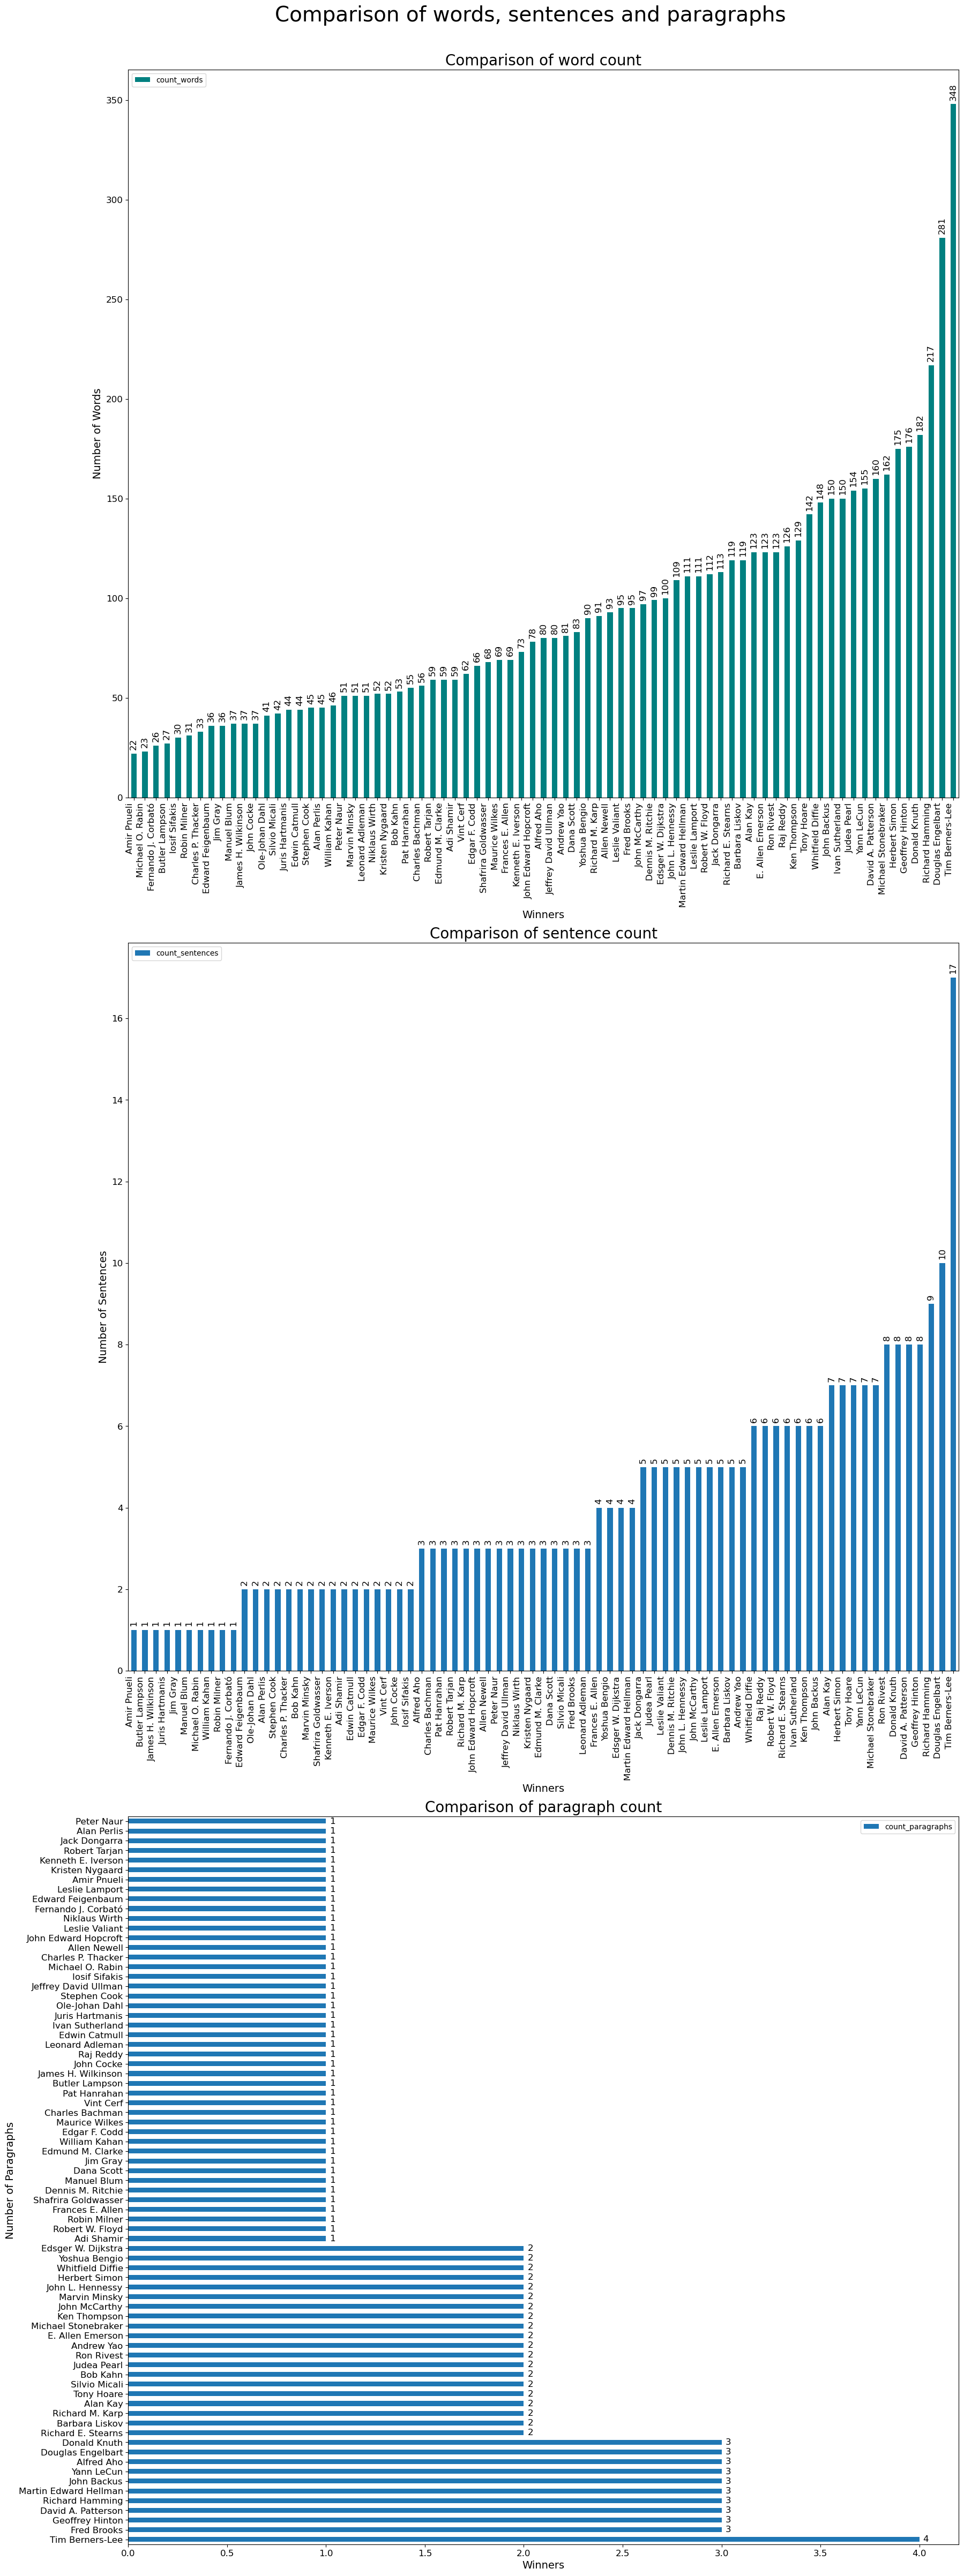

In [66]:
fig, axes = plt.subplots(3, figsize=(20, 60))
fig.suptitle("Comparison of words, sentences and paragraphs", x = 0.5, y = 0.90, fontsize = 28)
plt.rc('axes', titlesize = 20)
text_fontsize = 12
label_fontsize = 14

sorted_word_counts = award_winners_intro.sort_values("count_words").reset_index(drop=True)
sorted_sentence_counts = award_winners_intro.sort_values("count_sentences").reset_index(drop=True)
sorted_paragraph_counts = award_winners_intro.sort_values("count_paragraphs", ascending=False).reset_index(drop=True)

word_comparison = sorted_word_counts.plot(ax = axes[0], x="winner_name", y="count_words", kind='bar', title ="Comparison of word count", 
                                           legend=True, color="teal", fontsize=text_fontsize)                              
word_comparison.set_xlabel("Winners", fontsize=label_fontsize)
word_comparison.set_ylabel("Number of Words", fontsize=label_fontsize)
word_comparison.set_xticklabels(sorted_word_counts["winner_name"], rotation=90, ha='right')
word_comparison.bar_label(word_comparison.containers[0], rotation = 90, padding = 5, fontsize = text_fontsize)
word_comparison.legend(loc="upper left")

sentence_comparison = sorted_sentence_counts.plot(ax = axes[1], x="winner_name", y="count_sentences", kind='bar', title ="Comparison of sentence count", 
                                               legend=True, fontsize=text_fontsize)
sentence_comparison.set_xlabel("Winners", fontsize=label_fontsize)
sentence_comparison.set_ylabel("Number of Sentences", fontsize=label_fontsize)
sentence_comparison.set_xticklabels(sorted_sentence_counts["winner_name"], rotation=90, ha='right')
sentence_comparison.bar_label(sentence_comparison.containers[0], rotation = 90, padding = 5, fontsize = text_fontsize)
sentence_comparison.legend(loc="upper left")

paragraph_comparison = sorted_paragraph_counts.plot(ax = axes[2], x="winner_name", y="count_paragraphs", kind='barh', title ="Comparison of paragraph count", 
                                                legend=True, fontsize=text_fontsize)
paragraph_comparison.set_xlabel("Winners", fontsize=label_fontsize)
paragraph_comparison.set_ylabel("Number of Paragraphs", fontsize=label_fontsize)
paragraph_comparison.bar_label(paragraph_comparison.containers[0], padding = 5, fontsize = text_fontsize)

plt.show()

Task 14

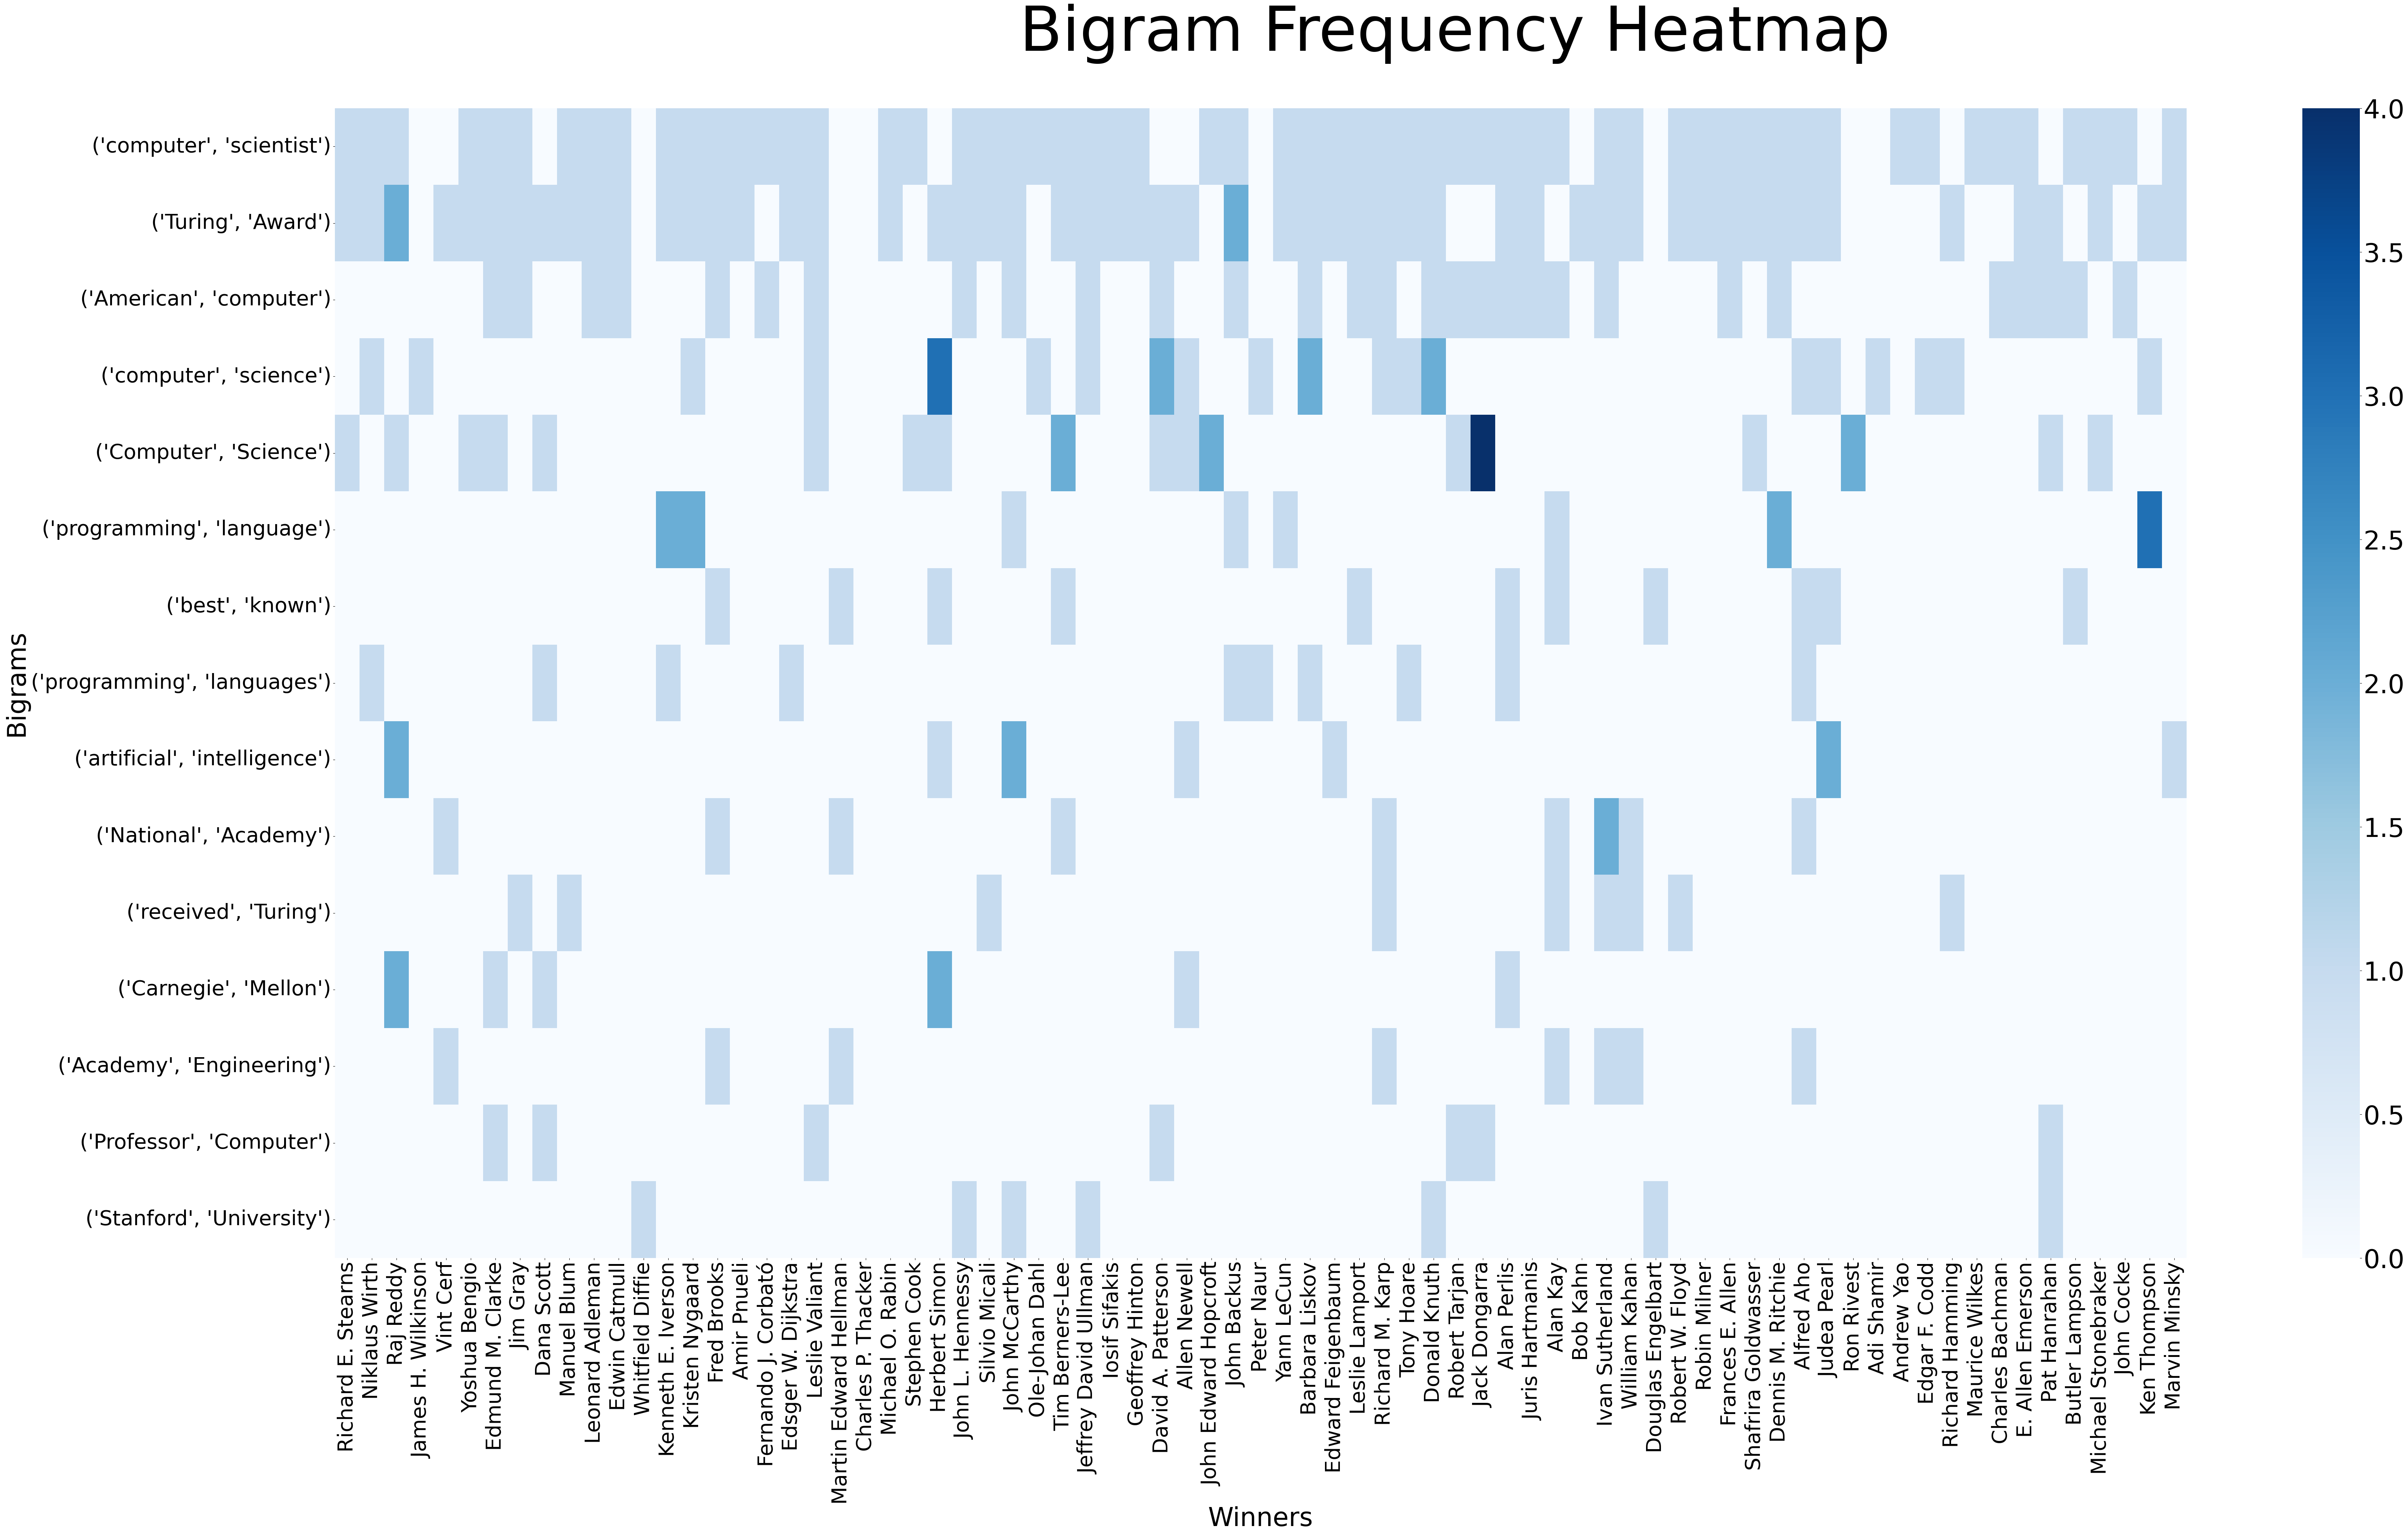

In [67]:
word_filter = set(stopwords.words('english') + list(string.punctuation) + ["``", "''", "–"])

combined_intro_texts = " ".join([BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]])
combined_tokenized_intros = word_tokenize(combined_intro_texts)
combined_intro_words = [word for word in combined_tokenized_intros if word.lower() not in word_filter]
winners_bigrams = dict(get_bigrams_frequency(combined_intro_words))

top15_bigrams = dict(sorted(winners_bigrams.items(), key=lambda bigram_dict: bigram_dict[1], reverse=True)[:15])

intro_texts = [BeautifulSoup(intro, "html.parser").get_text(" ") for intro in award_winners["intro"]]

bigram_frequencies = []
for intro in intro_texts:
    tokenized_intro = word_tokenize(intro)
    intro_words = [word for word in tokenized_intro if word.lower() not in word_filter]
    intro_bigrams = dict(get_bigrams_frequency(intro_words))

    top15_intro_bigrams = {key: intro_bigrams[key] for key in top15_bigrams.keys() if key in intro_bigrams.keys()}

    bigram_frequencies.append(top15_intro_bigrams)

heatmap_df = pd.DataFrame(index = [key for key in top15_bigrams.keys()], columns = award_winners_intro["winner_name"]) 
for i,winner in enumerate(heatmap_df.columns):
    for bigram in bigram_frequencies[i].keys():
        heatmap_df[winner][bigram] = bigram_frequencies[i][bigram]

heatmap_df.fillna(0, inplace=True)

fig = plt.figure(figsize=(80,40))
fig.suptitle("Bigram Frequency Heatmap", x = 0.5, y = 0.95, fontsize = 120)
bigram_heatmap = sns.heatmap(heatmap_df, annot=False, cmap="Blues")
bigram_heatmap.tick_params(labelsize=40)
bigram_heatmap.set_yticklabels(heatmap_df.index, rotation=0)
bigram_heatmap.set_xlabel("Winners", fontsize=50)
bigram_heatmap.set_ylabel("Bigrams", fontsize=50)
bigram_heatmap.collections[0].colorbar.ax.tick_params(labelsize=50)
plt.show()